# Information Theory and Inference: Final Project

# Transfer Entropy and Cryptocurrencies

Monti Sebastiano     2052399

Tonazzo Valentina     2060939

30/04/2023

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime

# Introduction 

Transfer entropy is a non-parametric statistics, measuring the amount of directed (time-asymmetric) transfer of information between two random processes. Transfer entropy from a process X to another process Y is the amount of uncertainty reduced in future values of Y by knowing the past values of X given past values of Y. More specifically, if $X_t$  and $Y_{t}$ for $t \in \mathbb{N}$  denote two random processes and the amount of information is measured using Shannon's entropy, the transfer entropy can be written as:

${\displaystyle T_{Y\rightarrow X}=H\left(X_{t}\mid X_{t-1}\right)-H\left(X_{t}\mid X_{t-1},Y_{t-1}\right),}$

where $H(X)$ is Shannon entropy of X. And so:

$H(X_t|X_{t-1})= H(X_t,X_{t-1}) - H(X_{t-1}) $

$H(X_t)=\frac{1}{2}log(2\pi eVar[X_t])$

$H(X_t,X_{t-1})=\frac{1}{2}log(2 \pi e |Σ|)$

Where $|Σ|$ represents the determinant of the covariance matrix. 
Transfer Entropy provides a powerful framework for analyzing causal relationships between complex dynamical systems, which are often characterized by multiple variables that interact in complex ways over time. In other words, it captures the directed influence or causal relationship between the two time series. This is a key advantage over other measures of dependence or correlation, such as cross-correlation or mutual information, which do not capture the direction of the influence.
Nowadays this statistic measuring has a wide range of applications in many fields, including neuroscience, physics, finance, and biology. For example, in neuroscience, transfer entropy has been used to analyze the information flow between different brain regions, shedding light on the mechanisms underlying cognition and behavior. In finance, transfer entropy has been used to study the dependence between different financial time series, providing insights into the dynamics of financial markets.

In this report, we investigate the transfer entropy between different time series related to cryptocurrencies in financial markets, with the aim of exploring the predictive relationships between these variables. Specifically, we examine the effect of time lag and the impact of considering multiple time series on the transfer entropy. As a second goal of this project we also investigate the impact of considering multiple time series on the transfer entropy, in order to check if the presece of more variables can help in predicting the future of anotherone.

## List of functions

In [3]:
def Entropy(X):
    return 0.5*np.log(2*np.pi*np.e*np.var(X))

def Joint_Entropy(stacked_X):
    cov_m = np.cov(stacked_X, rowvar=False)
    det = np.linalg.det(cov_m)
    return 0.5*np.log(det*((2*np.pi*np.e)**(np.shape(stacked_X)[1])))

def Cond_Entropy (X, stacked_X):
    if len(np.shape(stacked_X)) > 1:
        return Joint_Entropy(np.column_stack((X, stacked_X))) - Joint_Entropy(stacked_X)
    else:
        return Joint_Entropy(np.column_stack((X, stacked_X))) - Entropy(stacked_X)
    
def mutual_info(V1,V2):
  return Entropy(V1) + Entropy(V2) - Joint_Entropy(np.column_stack((V1, V2)))

def Transfer_Entropy (X, X1, Y1):
    X1Y1 = np.column_stack((X1, Y1))
    return Cond_Entropy(X, X1) - Cond_Entropy(X, X1Y1)

def Transfer_Entropy2 (DF, delta):

    X = DF[delta:,0]
    X1 = DF[:-delta,0]

    temp = np.arange(DF.shape[1])
    TE = np.array([])

    for i in range(1,DF.shape[1]):
      Y1 = DF[:-delta,i]

      selector = [x for x in range(DF.shape[1]) if( (x != 0) & (x!= i))]
      Z1 = DF[:-delta,selector]

      TE =np.append(TE, Cond_Entropy(X, np.column_stack((X1,Z1))) - Cond_Entropy(X, np.column_stack((X1,Y1,Z1))) ) 

    return TE

# Vector Autoregressive Model

$\vec{X_t} = (X_t,Y_t)$

$\vec{X_t} = A \vec{X}_{t-1} + \vec{ϵ} $

Where $A$ is a 2x2 matrix which eigenvalues are $\leq 1$. 

In [4]:
mu, sigma = 0, 0.5   # Mean and standard deviation of generated values

N = 1000   # Number of generated values

# Generate Gaussian distributed points
X_t = np.random.normal(mu, sigma, N)
Y_t = np.random.normal(mu, sigma, N)

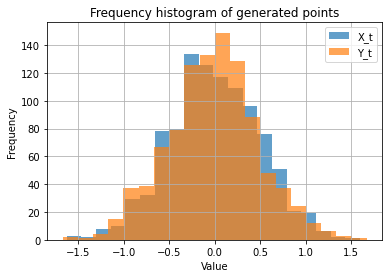

In [5]:
# Histogram of the generated points
plt.hist(X_t, bins=20, label = 'X_t', alpha = 0.7)
plt.hist(Y_t, bins=20, label = 'Y_t', alpha = 0.7)
plt.title("Frequency histogram of generated points")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [6]:
np.random.seed(1964)
# Define a simple matrix and a vector of gaussian random noise for the autoregressive model
A_sup = np.array([[0.5,0.5], [0,0.5]])   #Superior triangular matrix
A_inf = np.array([[0.5,0], [0.5,0.5]])   #Inferior triangular matrix
epsilon = np.random.normal(0, 0.1, (N, 2))


te_Y_X = np.array([])
te_X_Y = np.array([])

te_Y_X_inf = np.array([])
te_X_Y_inf = np.array([])

mX = np.array([])
mY = np.array([])
mX_inf = np.array([])
mY_inf = np.array([])

GcX = np.array([])
GcY = np.array([])

GcX_inf = np.array([])
GcY_inf = np.array([])

delta_t = np.arange(1, 101)   # Backward view time interval

for delta in delta_t:
  X_td = X_t[:-delta]   #Past values
  Y_td = Y_t[:-delta]
  X_t_adj = X_t[delta:]   #Present values vith adjusted dimensions
  Y_t_adj = Y_t[delta:]
  epsilon_d = epsilon[:-delta]

  XtdYtd = np.column_stack((X_td, Y_td))   #Stacked past values

  #print(np.shape(XtdYtd), np.shape(epsilon_d))
  X_td_prime = (np.dot(A_sup, XtdYtd.T) + epsilon_d.T).T   #VAE model using superior triangular matrix 
  X_td_prime_inf = (np.dot(A_inf, XtdYtd.T) + epsilon_d.T).T   #VAE model using inferior triangular matrix 

  #Transfer entropy values using superior triangular matrix
  te_Y_X = np.append(te_Y_X, Transfer_Entropy(X_td_prime[:, 0], XtdYtd[:, 0], XtdYtd[:, 1] ))    
  te_X_Y = np.append(te_X_Y, Transfer_Entropy(X_td_prime[:, 1], XtdYtd[:, 1], XtdYtd[:, 0] ))   

  #Transfer entropy values using inferior triangular matrix
  te_Y_X_inf = np.append(te_Y_X_inf, Transfer_Entropy(X_td_prime_inf[:, 0], XtdYtd[:, 0], XtdYtd[:, 1] ))   
  te_X_Y_inf = np.append(te_X_Y_inf, Transfer_Entropy(X_td_prime_inf[:, 1], XtdYtd[:, 1], XtdYtd[:, 0] ))

  #Mutual information calculation using superior triangular matrix 
  mX = np.append( mX, mutual_info(X_td_prime[:, 0], XtdYtd[:, 1]) )   #Between X_t (from VAE) e Y_{t-1} 
  mY = np.append( mY, mutual_info(X_td_prime[:, 1], XtdYtd[:, 0]) )   #Between X_t (from VAE) e Y_{t-1} 

  #Mutual information calculation using inferior triangular matrix
  mX_inf = np.append( mX_inf, mutual_info(X_td_prime_inf[:, 0], XtdYtd[:, 1]) )   #Between X_t (from VAE) e Y_{t-1} 
  mY_inf = np.append( mY_inf, mutual_info(X_td_prime_inf[:, 1], XtdYtd[:, 0]) )   #Between X_t (from VAE) e Y_{t-1} 

  #Calculation of granger causality test
  GcX = np.append( GcX, grangercausalitytests(pd.DataFrame(columns=['X_td_prime', 'Y_t_d'], data=zip(X_td_prime[:, 0], XtdYtd[:, 1])), 1, verbose=False)[1][0]["ssr_ftest"][1])   #Granger causality test result with delay time between 0 and 10
  GcY = np.append( GcY, grangercausalitytests(pd.DataFrame(columns=['Y_td_prime', 'X_t_d'], data=zip(X_td_prime[:, 1], XtdYtd[:, 0])), 1, verbose=False)[1][0]["ssr_ftest"][1])

  GcX_inf = np.append( GcX_inf, grangercausalitytests(pd.DataFrame(columns=['X_td_prime_inf', 'Y_t_d'], data=zip(X_td_prime_inf[:, 0], XtdYtd[:, 1])), 1, verbose=False)[1][0]["ssr_ftest"][1])   #Granger causality test result with delay time between 0 and 10
  GcY_inf = np.append( GcY_inf, grangercausalitytests(pd.DataFrame(columns=['Y_td_prime_inf', 'X_t_d'], data=zip(X_td_prime_inf[:, 1], XtdYtd[:, 0])), 1, verbose=False)[1][0]["ssr_ftest"][1])

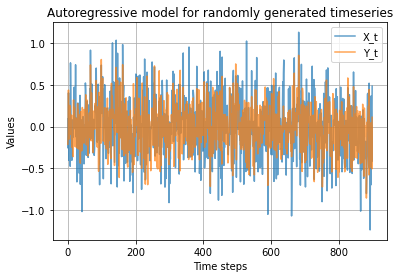

In [7]:
# Plot the timeseries
plt.plot(np.arange(len(X_td_prime[:, 0])), X_td_prime[:, 0], label = 'X_t', alpha = 0.7)
plt.plot(np.arange(len(X_td_prime[:, 1])), X_td_prime[:, 1], label = 'Y_t', alpha = 0.7)
plt.title('Autoregressive model for randomly generated timeseries')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend(loc = 'best')
plt.grid()

## Transfer entropy

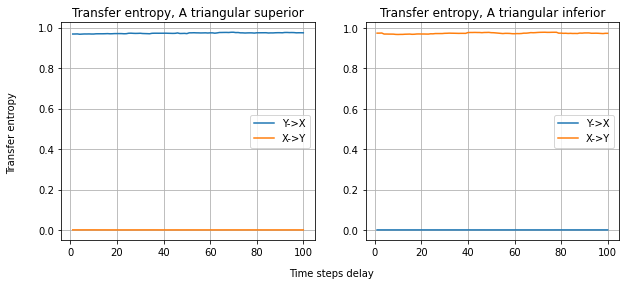

In [8]:
# Transfer entropy plots
fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(10, 4))
ax[0].plot(delta_t, te_Y_X, label = 'Y->X')
ax[0].plot(delta_t, te_X_Y, label = 'X->Y')
ax[0].set_title("Transfer entropy, A triangular superior")
ax[0].grid()
ax[1].plot(delta_t, te_Y_X_inf, label = 'Y->X')
ax[1].plot(delta_t, te_X_Y_inf, label = 'X->Y')
ax[1].set_title("Transfer entropy, A triangular inferior")
ax[1].grid()
fig.text(0.5, 0, 'Time steps delay', ha='center')
fig.text(0.05, 0.5, 'Transfer entropy', va='center', rotation='vertical')
ax[0].legend()
ax[1].legend()

## Mutual information


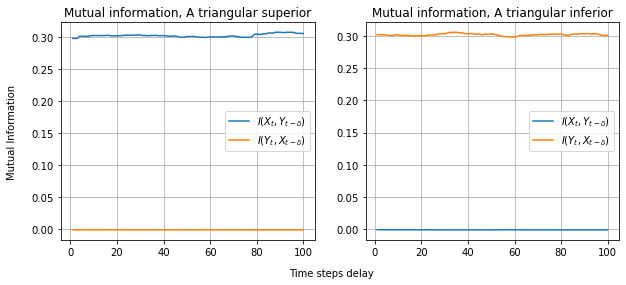

In [9]:
# Mutual information plots
fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(10, 4))
ax[0].plot(delta_t, mX, label = '$I(X_t,Y_{t-\delta})$')
ax[0].plot(delta_t, mY, label = '$I(Y_t,X_{t-\delta})$')
ax[0].set_title("Mutual information, A triangular superior")
ax[0].grid()
ax[1].plot(delta_t, mX_inf, label = '$I(X_t,Y_{t-\delta})$')
ax[1].plot(delta_t, mY_inf, label = '$I(Y_t,X_{t-\delta})$')
ax[1].set_title("Mutual information, A triangular inferior")
ax[1].grid()
fig.text(0.5, 0, 'Time steps delay', ha='center')
fig.text(0.05, 0.5, 'Mutual Information', va='center', rotation='vertical')
ax[0].legend()
ax[1].legend()

## Granger causality

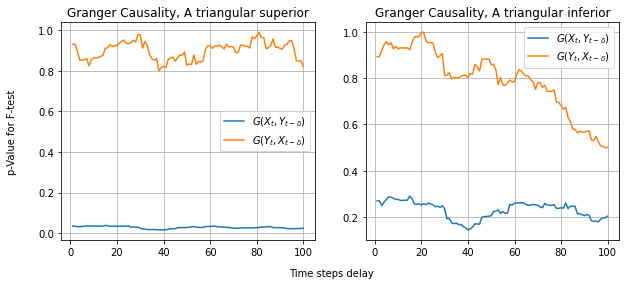

In [10]:
# Plots from Granger causality test
fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(10, 4))
ax[0].plot(delta_t, GcX, label = '$G(X_t,Y_{t-\delta})$')
ax[0].plot(delta_t, GcY, label = '$G(Y_t,X_{t-\delta})$')
ax[0].set_title("Granger Causality, A triangular superior")
ax[0].grid()
ax[1].plot(delta_t, GcY_inf, label = '$G(X_t,Y_{t-\delta})$')
ax[1].plot(delta_t, GcX_inf, label = '$G(Y_t,X_{t-\delta})$')
ax[1].set_title("Granger Causality, A triangular inferior")
ax[1].grid()
fig.text(0.5, 0, 'Time steps delay', ha='center')
fig.text(0.05, 0.5, 'p-Value for F-test', va='center', rotation='vertical')
ax[0].legend()
ax[1].legend()

When the p-value is less than 0.05, we can reject the null hypothesis of the test and conclude that the knowledge of the variable in the second column is useful to predict the variable in the first column.

# Transfer entropy of cryptocurrencies' historical data

## Bitcoin - Ethereum case

In [11]:
# Reading the data and preprocessing
fixed_str = '-USD.csv'
file_names = ['BTC-USD.csv', 'ETH-USD.csv']

delta_t = np.arange(1, (365*3)+1)

BTC_ETH_df = pd.concat((pd.read_csv(filename, usecols = ['Date', 'Adj Close'], index_col = 'Date') for filename in file_names), axis = 1)
BTC_ETH_df.columns = [filename.replace(fixed_str,'') for filename in file_names]
BTC_ETH_df.index = pd.to_datetime(BTC_ETH_df.index)
BTC_ETH_df = BTC_ETH_df.dropna()

BTC_ETH_df = np.log10(BTC_ETH_df) - np.log10(BTC_ETH_df.iloc[0])

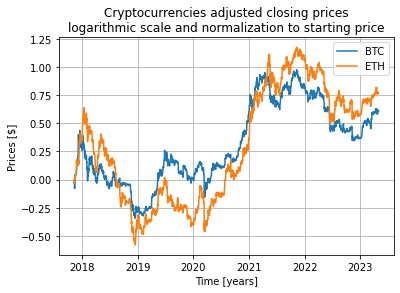

In [12]:
# Data visualization
plt.plot(BTC_ETH_df, label = BTC_ETH_df.columns)
plt.title('Cryptocurrencies adjusted closing prices\nlogarithmic scale and normalization to starting price')
plt.xlabel('Time [years]')
plt.ylabel('Prices [$]')
plt.legend(loc = 'best')
plt.grid()

In [13]:
# Transfer entropy calculation for a range of time windows
te_ETH_BTC = np.array([])
te_BTC_ETH = np.array([])

for delta in delta_t:
    te_ETH_BTC = np.append(te_ETH_BTC, Transfer_Entropy(BTC_ETH_df.iloc[delta:, 0].values, BTC_ETH_df.iloc[:-delta, 0].values, BTC_ETH_df.iloc[:-delta, 1].values))
    te_BTC_ETH = np.append(te_BTC_ETH, Transfer_Entropy(BTC_ETH_df.iloc[delta:, 1].values, BTC_ETH_df.iloc[:-delta, 1].values, BTC_ETH_df.iloc[:-delta, 0].values))

m_BTC_ETH = mutual_info(BTC_ETH_df["BTC"].values, BTC_ETH_df["ETH"].values)
print("Mutual information: I(BTC | ETH) = ", m_BTC_ETH)

Mutual information: I(BTC | ETH) =  0.9815706880138919


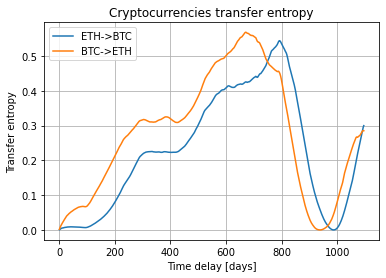

In [14]:
# Transfer entropy visualization
plt.plot(delta_t, te_ETH_BTC, label = 'ETH->BTC')
plt.plot(delta_t, te_BTC_ETH, label = 'BTC->ETH')
#plt.plot(delta_t, m_BTC_ETH * np.ones(len(delta_t)), label = 'I(BTC|ETH)')
plt.title('Cryptocurrencies transfer entropy')
plt.xlabel('Time delay [days]')
plt.ylabel('Transfer entropy')
plt.legend(loc = 'best')
plt.grid()

In [15]:
# Granger causality tests
BTC_ETH_gc_res = grangercausalitytests(pd.DataFrame(columns=['BTC', 'ETH'], data=zip(BTC_ETH_df['BTC'].values, BTC_ETH_df['ETH'].values)), 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1514  , p=0.0760  , df_denom=1995, df_num=1
ssr based chi2 test:   chi2=3.1561  , p=0.0756  , df=1
likelihood ratio test: chi2=3.1536  , p=0.0758  , df=1
parameter F test:         F=3.1514  , p=0.0760  , df_denom=1995, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5950  , p=0.0005  , df_denom=1992, df_num=2
ssr based chi2 test:   chi2=15.2282 , p=0.0005  , df=2
likelihood ratio test: chi2=15.1704 , p=0.0005  , df=2
parameter F test:         F=7.5950  , p=0.0005  , df_denom=1992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7942  , p=0.0006  , df_denom=1989, df_num=3
ssr based chi2 test:   chi2=17.4436 , p=0.0006  , df=3
likelihood ratio test: chi2=17.3679 , p=0.0006  , df=3
parameter F test:         F=5.7942  , p=0.0006  , df_denom=1989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1715  , p=0.

## More cryptocurrencies together

In [16]:
# Reading the data and preprocessing
fixed_str = '-USD.csv'
file_names = ['BTC-USD.csv', 'ETH-USD.csv', 'DOGE-USD.csv', 'BNB-USD.csv', 'XRP-USD.csv', 'ADA-USD.csv']

df = pd.concat((pd.read_csv(filename, usecols = ['Date', 'Adj Close'], index_col = 'Date') for filename in file_names), axis = 1)
df.columns = [filename.replace(fixed_str,'') for filename in file_names]
df.index = pd.to_datetime(df.index)
df = df.dropna()

df = np.log10(df) - np.log10(df.iloc[0])
df

,BTC,ETH,DOGE,BNB,XRP,ADA
Date,,,,,,
2017-11-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-11-10,-0.033180,-0.030310,-0.085177,-0.044512,-0.022551,-0.072595
2017-11-11,-0.050623,-0.008478,-0.071213,-0.076182,-0.014328,-0.067532
2017-11-12,-0.079394,-0.017927,-0.134559,-0.117266,-0.042222,-0.126074
2017-11-13,-0.037046,-0.005678,-0.067612,-0.072004,-0.028995,-0.094114
...,...,...,...,...,...,...
2023-04-26,0.599749,0.764695,1.744793,2.220573,0.327241,1.097815
2023-04-27,0.615520,0.774409,1.753364,2.221063,0.331759,1.106749
2023-04-28,0.613548,0.770691,1.754305,2.212194,0.344051,1.101513


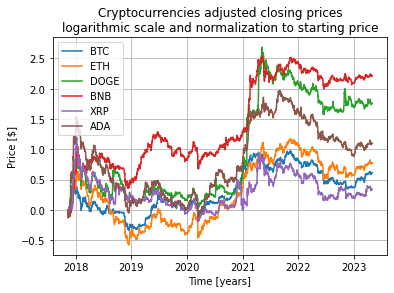

In [17]:
# Data visualization
plt.plot(df, label = df.columns)
plt.title('Cryptocurrencies adjusted closing prices\nlogarithmic scale and normalization to starting price')
plt.xlabel('Time [years]')
plt.ylabel('Price [$]')
plt.legend(loc = 'best')
plt.grid()

In the following cell the transfer entropy between cryptocurrency timeseries is computed as follows.

${\displaystyle T_{Y\rightarrow X}=H\left(X_{t}\mid X_{t-1}, Z_{t-1}\right)-H\left(X_{t}\mid X_{t-1}, Y_{t-1}, Z_{t-1}\right)}$

Where $X_{t}$ is represented by the bitcoin timeseries, $Y_{t}$ represent another cryptocurrency timeseries chosen among the possible ones and $Z_{t}$ incorporates all the remaining ones.

In [18]:
# Transfer entropy calculation for a range of time windows
np_data = df.to_numpy()

te = Transfer_Entropy2(np_data, 1)
delta_t = np.arange(1, (365*1)+1)

for i in delta_t[1:]:
    te = np.vstack((te, Transfer_Entropy2(np_data, i)))

#print(te)

In [19]:
te_df = pd.DataFrame(te, columns = ['BTC-ETH','BTC-DOGE','BTC-BNB', 'BTC-XRP', 'BTC-ADA'], index = delta_t)

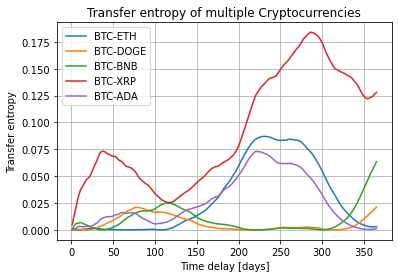

In [20]:
# Data visualization
plt.plot(te_df, label = te_df.columns)
plt.title('Transfer entropy of multiple Cryptocurrencies')
plt.xlabel('Time delay [days]')
plt.ylabel('Transfer entropy')
plt.legend(loc = 'best')
plt.grid()